## Import Libraries

In [1]:
import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from collections import Counter
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, GaussianBlur, Grayscale
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, Dataset

import cv2 
from PIL import Image, ImageFilter, ImageOps
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # as M1 Mac Does not have a dedicated GPU

##### Specify the path to the locally saved dataset

In [3]:
train_data_dir = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset'
original_dataset = datasets.ImageFolder(train_data_dir)

In [4]:
class ContrastStretching:
    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Check if the image is grayscale or RGB
        if img_np.ndim == 2:  # Grayscale image
            img_np = self.apply_contrast_stretching(img_np)
        elif img_np.ndim == 3:  # RGB image
            # Apply contrast stretching to each channel individually
            for i in range(img_np.shape[-1]):
                img_np[:, :, i] = self.apply_contrast_stretching(img_np[:, :, i])
        
        # Convert back to PIL Image
        return Image.fromarray(img_np.astype('uint8'))
    
    def apply_contrast_stretching(self, channel):
        in_min, in_max = np.percentile(channel, (0, 100))
        out_min, out_max = 0, 255
        channel = np.clip((channel - in_min) * (out_max - out_min) / (in_max - in_min) + out_min, out_min, out_max)
        return channel

class UnsharpMask:
    def __init__(self, radius=1, percent=100, threshold=3):
        self.radius = radius
        self.percent = percent
        self.threshold = threshold

    def __call__(self, img):
        return img.filter(ImageFilter.UnsharpMask(radius=self.radius, 
                                                  percent=self.percent, 
                                                  threshold=self.threshold
                                                 ))

class GaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        sigma = np.random.uniform(self.sigma[0], self.sigma[1])
        img = img.filter(ImageFilter.GaussianBlur(sigma))
        return img

#### Preprocess the dataset

In [5]:
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ContrastStretching(),
    UnsharpMask(radius=1, percent=100, threshold=3),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
])

preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [35]:
def calculate_psnr_ssim(original_dataset, preprocessed_dataset, num_samples=100, resize=(224, 224)):
    psnr_values = []
    ssim_values = []

    for i in range(num_samples):
        original_img = original_dataset[i][0] # original MRI
        preprocessed_img = preprocessed_dataset[i][0] # preprocessed MRI

        if not isinstance(original_img, Image.Image):
            original_img = to_pil_image(original_img)
        if not isinstance(preprocessed_img, Image.Image):
            preprocessed_img = to_pil_image(preprocessed_img)

        # Convert MRI to grayscale
        original_img = original_img.convert("L")
        preprocessed_img = preprocessed_img.convert("L")

        # Resize images
        original_img = original_img.resize(resize)
        preprocessed_img = preprocessed_img.resize(resize)

        # Convert images to numpy arrays
        original_img_np = np.array(original_img)
        preprocessed_img_np = np.array(preprocessed_img)

        # Calculate PSNR and SSIM
        psnr = peak_signal_noise_ratio(original_img_np, preprocessed_img_np, data_range=original_img_np.max() - original_img_np.min())
        ssim = structural_similarity(original_img_np, preprocessed_img_np)

        psnr_values.append(psnr)
        ssim_values.append(ssim)

    # Compute average PSNR and SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Example usage
avg_psnr, avg_ssim = calculate_psnr_ssim(original_dataset, preprocessed_dataset)
print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")

Average PSNR: 27.424622806629483, Average SSIM: 0.9004132035124346


preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.Lambda(lambda x: x.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))),
    transforms.ToTensor()
)

Average PSNR: 9.729432125669954, Average SSIM: 0.2833625979364462
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.ToTensor()
)

Average PSNR: 10.2026194786185, Average SSIM: 0.32374658927511385
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)), 
    transforms.ToTensor(),
)

Average PSNR: 34.479706650199184, Average SSIM: 0.9638484917028203

____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.0)), 
    transforms.ToTensor(),
)

Average PSNR: 40.03000513450271, Average SSIM: 0.9923509776637894

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 28.919164968402907, Average SSIM: 0.9646276430637585

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    ContrastStretching(),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=1, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 27.194490517269728, Average SSIM: 0.8948121010151182

#### MRI scan counts in each class of the dataset

In [6]:
MildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented = '/Users/savin/Desktop/FYP/Implementation/kaggle_dataset/AugmentedAlzheimerDataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 8960
Number of images in ModerateDemented: 6464
Number of images in NonDemented: 9600
Number of images in VeryMildDemented: 8960

Total MRIs in the dataset = 33984


#### Sample MRI before and after preprocessing

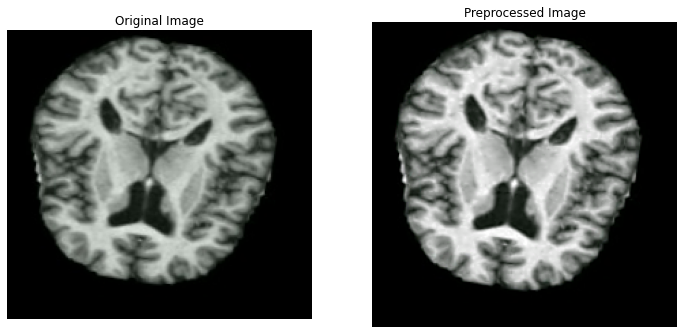

In [7]:
sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[0])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

### Dataset splitting & creating DataLoaders

In [8]:
train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

## Building CNN Model 1

In [9]:
class CNN1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(384)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(384 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.output = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01)
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn6(self.conv6(x)), negative_slope=0.01)

        x = x.view(x.size(0), -1)

        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.01))
        x = self.dropout(F.leaky_relu(self.fc2(x), negative_slope=0.01))
        
        x = self.output(x)

        return x

model1 = CNN1(num_classes=4)

summary(model1, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
       BatchNorm2d-2           [-1, 64, 55, 55]             128
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 128, 27, 27]         204,928
       BatchNorm2d-5          [-1, 128, 27, 27]             256
         MaxPool2d-6          [-1, 128, 13, 13]               0
            Conv2d-7          [-1, 256, 13, 13]         295,168
       BatchNorm2d-8          [-1, 256, 13, 13]             512
            Conv2d-9          [-1, 256, 13, 13]         590,080
      BatchNorm2d-10          [-1, 256, 13, 13]             512
           Conv2d-11          [-1, 256, 13, 13]         590,080
      BatchNorm2d-12          [-1, 256, 13, 13]             512
        MaxPool2d-13            [-1, 256, 6, 6]               0
           Conv2d-14            [-1, 38

## Training CNN Model 1

Epoch 1 [train] Progress: 100%|████████████| 744/744 [21:15<00:00,  1.71s/batch]


train Loss: 1.3237 Acc: 0.3816


Epoch 1 [val] Progress: 100%|██████████████| 160/160 [01:07<00:00,  2.38batch/s]


val Loss: 1.6542 Acc: 0.2733


Epoch 2 [train] Progress: 100%|████████████| 744/744 [23:48<00:00,  1.92s/batch]


train Loss: 1.0275 Acc: 0.5185


Epoch 2 [val] Progress: 100%|██████████████| 160/160 [01:14<00:00,  2.15batch/s]


val Loss: 0.9786 Acc: 0.5458


Epoch 3 [train] Progress: 100%|████████████| 744/744 [22:56<00:00,  1.85s/batch]


train Loss: 0.8535 Acc: 0.5903


Epoch 3 [val] Progress: 100%|██████████████| 160/160 [01:09<00:00,  2.32batch/s]


val Loss: 0.8713 Acc: 0.5548


Epoch 4 [train] Progress: 100%|████████████| 744/744 [22:30<00:00,  1.81s/batch]


train Loss: 0.7914 Acc: 0.6234


Epoch 4 [val] Progress: 100%|██████████████| 160/160 [01:10<00:00,  2.25batch/s]


val Loss: 0.9906 Acc: 0.5360


Epoch 5 [train] Progress: 100%|████████████| 744/744 [25:41<00:00,  2.07s/batch]


train Loss: 0.7477 Acc: 0.6436


Epoch 5 [val] Progress: 100%|██████████████| 160/160 [02:02<00:00,  1.30batch/s]


val Loss: 0.8744 Acc: 0.5386


Epoch 6 [train] Progress: 100%|████████████| 744/744 [29:59<00:00,  2.42s/batch]


train Loss: 0.7006 Acc: 0.6719


Epoch 6 [val] Progress: 100%|██████████████| 160/160 [01:33<00:00,  1.71batch/s]


val Loss: 1.0309 Acc: 0.4930


Epoch 7 [train] Progress: 100%|████████████| 744/744 [30:29<00:00,  2.46s/batch]


train Loss: 0.6696 Acc: 0.6910


Epoch 7 [val] Progress: 100%|██████████████| 160/160 [01:39<00:00,  1.61batch/s]


val Loss: 1.3398 Acc: 0.4815


Epoch 8 [train] Progress: 100%|████████████| 744/744 [30:44<00:00,  2.48s/batch]


train Loss: 0.6261 Acc: 0.7121


Epoch 8 [val] Progress: 100%|██████████████| 160/160 [01:33<00:00,  1.71batch/s]


val Loss: 0.6014 Acc: 0.7326


Epoch 9 [train] Progress: 100%|████████████| 744/744 [27:28<00:00,  2.22s/batch]


train Loss: 0.5959 Acc: 0.7293


Epoch 9 [val] Progress: 100%|██████████████| 160/160 [01:30<00:00,  1.77batch/s]


val Loss: 0.9389 Acc: 0.6620


Epoch 10 [train] Progress: 100%|███████████| 744/744 [27:21<00:00,  2.21s/batch]


train Loss: 0.5518 Acc: 0.7505


Epoch 10 [val] Progress: 100%|█████████████| 160/160 [01:28<00:00,  1.81batch/s]


val Loss: 0.4871 Acc: 0.7726


Epoch 11 [train] Progress: 100%|███████████| 744/744 [26:24<00:00,  2.13s/batch]


train Loss: 0.5218 Acc: 0.7577


Epoch 11 [val] Progress: 100%|█████████████| 160/160 [01:22<00:00,  1.94batch/s]


val Loss: 0.4733 Acc: 0.7777


Epoch 12 [train] Progress: 100%|███████████| 744/744 [26:38<00:00,  2.15s/batch]


train Loss: 0.4946 Acc: 0.7765


Epoch 12 [val] Progress: 100%|█████████████| 160/160 [01:25<00:00,  1.87batch/s]


val Loss: 0.6057 Acc: 0.6937


Epoch 13 [train] Progress: 100%|███████████| 744/744 [27:27<00:00,  2.21s/batch]


train Loss: 0.4705 Acc: 0.7880


Epoch 13 [val] Progress: 100%|█████████████| 160/160 [01:28<00:00,  1.80batch/s]


val Loss: 0.4687 Acc: 0.7742


Epoch 14 [train] Progress: 100%|███████████| 744/744 [26:45<00:00,  2.16s/batch]


train Loss: 0.4379 Acc: 0.8028


Epoch 14 [val] Progress: 100%|█████████████| 160/160 [01:26<00:00,  1.84batch/s]


val Loss: 0.4712 Acc: 0.7932


Epoch 15 [train] Progress: 100%|███████████| 744/744 [26:14<00:00,  2.12s/batch]


train Loss: 0.4182 Acc: 0.8155


Epoch 15 [val] Progress: 100%|█████████████| 160/160 [01:21<00:00,  1.96batch/s]


val Loss: 0.3934 Acc: 0.8413


Epoch 16 [train] Progress: 100%|███████████| 744/744 [26:32<00:00,  2.14s/batch]


train Loss: 0.3904 Acc: 0.8286


Epoch 16 [val] Progress: 100%|█████████████| 160/160 [01:25<00:00,  1.88batch/s]


val Loss: 0.3664 Acc: 0.8466


Epoch 17 [train] Progress: 100%|███████████| 744/744 [25:33<00:00,  2.06s/batch]


train Loss: 0.3673 Acc: 0.8415


Epoch 17 [val] Progress: 100%|█████████████| 160/160 [01:19<00:00,  2.02batch/s]


val Loss: 0.4622 Acc: 0.8170


Epoch 18 [train] Progress: 100%|███████████| 744/744 [25:58<00:00,  2.10s/batch]


train Loss: 0.3430 Acc: 0.8559


Epoch 18 [val] Progress: 100%|█████████████| 160/160 [01:20<00:00,  1.99batch/s]


val Loss: 0.3063 Acc: 0.8687


Epoch 19 [train] Progress: 100%|███████████| 744/744 [26:59<00:00,  2.18s/batch]


train Loss: 0.3278 Acc: 0.8625


Epoch 19 [val] Progress: 100%|█████████████| 160/160 [01:25<00:00,  1.87batch/s]


val Loss: 0.3276 Acc: 0.8476


Epoch 20 [train] Progress: 100%|███████████| 744/744 [25:34<00:00,  2.06s/batch]


train Loss: 0.2920 Acc: 0.8806


Epoch 20 [val] Progress: 100%|█████████████| 160/160 [01:27<00:00,  1.83batch/s]


val Loss: 0.3053 Acc: 0.8705


Epoch 21 [train] Progress: 100%|███████████| 744/744 [24:47<00:00,  2.00s/batch]


train Loss: 0.2772 Acc: 0.8877


Epoch 21 [val] Progress: 100%|█████████████| 160/160 [01:21<00:00,  1.96batch/s]


val Loss: 0.2119 Acc: 0.9149


Epoch 22 [train] Progress: 100%|███████████| 744/744 [24:13<00:00,  1.95s/batch]


train Loss: 0.2597 Acc: 0.8954


Epoch 22 [val] Progress: 100%|█████████████| 160/160 [01:20<00:00,  1.99batch/s]


val Loss: 0.3000 Acc: 0.8958


Epoch 23 [train] Progress: 100%|███████████| 744/744 [22:59<00:00,  1.85s/batch]


train Loss: 0.2412 Acc: 0.9051


Epoch 23 [val] Progress: 100%|█████████████| 160/160 [01:14<00:00,  2.14batch/s]


val Loss: 0.2290 Acc: 0.9154


Epoch 24 [train] Progress: 100%|███████████| 744/744 [29:18<00:00,  2.36s/batch]


train Loss: 0.2233 Acc: 0.9131


Epoch 24 [val] Progress: 100%|█████████████| 160/160 [01:16<00:00,  2.09batch/s]


val Loss: 0.2386 Acc: 0.9160


Epoch 25 [train] Progress: 100%|███████████| 744/744 [24:00<00:00,  1.94s/batch]


train Loss: 0.2051 Acc: 0.9218


Epoch 25 [val] Progress: 100%|█████████████| 160/160 [01:15<00:00,  2.12batch/s]


val Loss: 0.5017 Acc: 0.8713


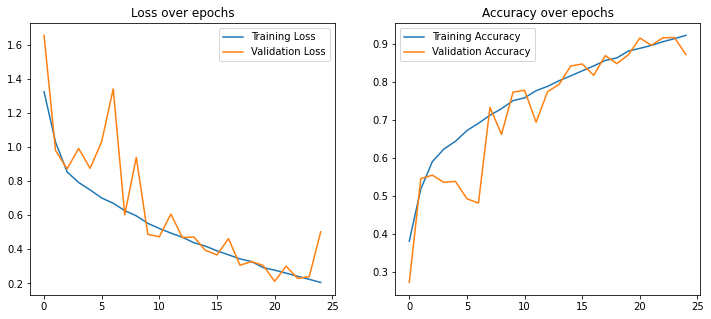

In [345]:
model1 = CNN1(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_epoch(epoch_index, train_loader, model, optimizer):
    model.train()  
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    model.eval() 
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

# Training loop
num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, model1, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, model1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model1.state_dict(), 'model1.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

In [118]:
# classification report (test loader) - modified AlexNet
model1 = CNN1(num_classes=4).to(device)

model1.load_state_dict(torch.load('CNN2.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model1, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.99      0.71      0.83      1351
ModerateDemented       0.78      1.00      0.87       939
     NonDemented       0.82      0.92      0.87      1427
VeryMildDemented       0.81      0.77      0.79      1382

        accuracy                           0.84      5099
       macro avg       0.85      0.85      0.84      5099
    weighted avg       0.85      0.84      0.84      5099



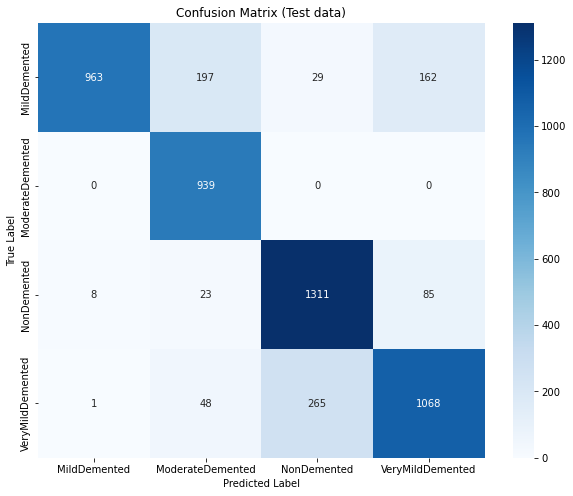

In [119]:
# Confusion Matrix on Test Loader

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(model1, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Building CNN Model 2

In [12]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=32):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class CNN2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN2, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        num_ftrs = self.base_model.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        self.base_model.features.add_module("SEBlock", SEBlock(1280))  

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model2 = CNN2(num_classes=4).to(device)

summary(model2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

## Train CNN Model 2

Epoch 1 [train] Progress: 100%|████████████| 744/744 [21:46<00:00,  1.76s/batch]


train Loss: 1.1749 Acc: 0.4637


Epoch 1 [val] Progress: 100%|██████████████| 160/160 [03:45<00:00,  1.41s/batch]


val Loss: 1.0197 Acc: 0.5484


Epoch 2 [train] Progress: 100%|████████████| 744/744 [20:26<00:00,  1.65s/batch]


train Loss: 1.0291 Acc: 0.5413


Epoch 2 [val] Progress: 100%|██████████████| 160/160 [04:06<00:00,  1.54s/batch]


val Loss: 0.9474 Acc: 0.5711


Epoch 3 [train] Progress: 100%|████████████| 744/744 [20:36<00:00,  1.66s/batch]


train Loss: 0.9919 Acc: 0.5575


Epoch 3 [val] Progress: 100%|██████████████| 160/160 [03:58<00:00,  1.49s/batch]


val Loss: 0.9241 Acc: 0.5831


Epoch 4 [train] Progress: 100%|████████████| 744/744 [19:22<00:00,  1.56s/batch]


train Loss: 0.9617 Acc: 0.5698


Epoch 4 [val] Progress: 100%|██████████████| 160/160 [03:49<00:00,  1.44s/batch]


val Loss: 0.9065 Acc: 0.5878


Epoch 5 [train] Progress: 100%|████████████| 744/744 [19:22<00:00,  1.56s/batch]


train Loss: 0.9411 Acc: 0.5772


Epoch 5 [val] Progress: 100%|██████████████| 160/160 [03:52<00:00,  1.45s/batch]


val Loss: 0.8903 Acc: 0.5974


Epoch 6 [train] Progress: 100%|████████████| 744/744 [19:29<00:00,  1.57s/batch]


train Loss: 0.9248 Acc: 0.5859


Epoch 6 [val] Progress: 100%|██████████████| 160/160 [03:49<00:00,  1.44s/batch]


val Loss: 0.8699 Acc: 0.6108


Epoch 7 [train] Progress: 100%|████████████| 744/744 [20:22<00:00,  1.64s/batch]


train Loss: 0.9078 Acc: 0.5948


Epoch 7 [val] Progress: 100%|██████████████| 160/160 [03:55<00:00,  1.47s/batch]


val Loss: 0.8693 Acc: 0.6117


Epoch 8 [train] Progress: 100%|████████████| 744/744 [21:16<00:00,  1.72s/batch]


train Loss: 0.8992 Acc: 0.5998


Epoch 8 [val] Progress: 100%|██████████████| 160/160 [04:31<00:00,  1.69s/batch]


val Loss: 0.8422 Acc: 0.6219


Epoch 9 [train] Progress: 100%|████████████| 744/744 [23:42<00:00,  1.91s/batch]


train Loss: 0.8852 Acc: 0.6064


Epoch 9 [val] Progress: 100%|██████████████| 160/160 [03:52<00:00,  1.45s/batch]


val Loss: 0.8371 Acc: 0.6225


Epoch 10 [train] Progress: 100%|███████████| 744/744 [19:07<00:00,  1.54s/batch]


train Loss: 0.8778 Acc: 0.6109


Epoch 10 [val] Progress: 100%|█████████████| 160/160 [03:56<00:00,  1.48s/batch]


val Loss: 0.8302 Acc: 0.6261


Epoch 11 [train] Progress: 100%|███████████| 744/744 [20:31<00:00,  1.66s/batch]


train Loss: 0.8650 Acc: 0.6160


Epoch 11 [val] Progress: 100%|█████████████| 160/160 [03:59<00:00,  1.50s/batch]


val Loss: 0.8128 Acc: 0.6335


Epoch 12 [train] Progress: 100%|███████████| 744/744 [20:46<00:00,  1.68s/batch]


train Loss: 0.8588 Acc: 0.6170


Epoch 12 [val] Progress: 100%|█████████████| 160/160 [04:08<00:00,  1.55s/batch]


val Loss: 0.8048 Acc: 0.6386


Epoch 13 [train] Progress: 100%|███████████| 744/744 [20:24<00:00,  1.65s/batch]


train Loss: 0.8471 Acc: 0.6223


Epoch 13 [val] Progress: 100%|█████████████| 160/160 [04:09<00:00,  1.56s/batch]


val Loss: 0.8037 Acc: 0.6327


Epoch 14 [train] Progress: 100%|███████████| 744/744 [18:30<00:00,  1.49s/batch]


train Loss: 0.8407 Acc: 0.6268


Epoch 14 [val] Progress: 100%|█████████████| 160/160 [03:36<00:00,  1.35s/batch]


val Loss: 0.7894 Acc: 0.6435


Epoch 15 [train] Progress: 100%|███████████| 744/744 [20:12<00:00,  1.63s/batch]


train Loss: 0.8244 Acc: 0.6338


Epoch 15 [val] Progress: 100%|█████████████| 160/160 [04:03<00:00,  1.52s/batch]


val Loss: 0.7911 Acc: 0.6431


Epoch 16 [train] Progress: 100%|███████████| 744/744 [20:49<00:00,  1.68s/batch]


train Loss: 0.8245 Acc: 0.6343


Epoch 16 [val] Progress: 100%|█████████████| 160/160 [04:02<00:00,  1.52s/batch]


val Loss: 0.7779 Acc: 0.6463


Epoch 17 [train] Progress: 100%|███████████| 744/744 [20:42<00:00,  1.67s/batch]


train Loss: 0.8218 Acc: 0.6384


Epoch 17 [val] Progress: 100%|█████████████| 160/160 [04:08<00:00,  1.55s/batch]


val Loss: 0.7717 Acc: 0.6484


Epoch 18 [train] Progress: 100%|███████████| 744/744 [20:49<00:00,  1.68s/batch]


train Loss: 0.8035 Acc: 0.6455


Epoch 18 [val] Progress: 100%|█████████████| 160/160 [04:03<00:00,  1.52s/batch]


val Loss: 0.7744 Acc: 0.6461


Epoch 19 [train] Progress: 100%|███████████| 744/744 [20:21<00:00,  1.64s/batch]


train Loss: 0.8026 Acc: 0.6472


Epoch 19 [val] Progress: 100%|█████████████| 160/160 [03:59<00:00,  1.50s/batch]


val Loss: 0.7612 Acc: 0.6580


Epoch 20 [train] Progress: 100%|███████████| 744/744 [20:16<00:00,  1.63s/batch]


train Loss: 0.7898 Acc: 0.6558


Epoch 20 [val] Progress: 100%|█████████████| 160/160 [03:53<00:00,  1.46s/batch]


val Loss: 0.7550 Acc: 0.6588


Epoch 21 [train] Progress: 100%|███████████| 744/744 [20:09<00:00,  1.63s/batch]


train Loss: 0.7845 Acc: 0.6557


Epoch 21 [val] Progress: 100%|█████████████| 160/160 [03:58<00:00,  1.49s/batch]


val Loss: 0.7544 Acc: 0.6571


Epoch 22 [train] Progress: 100%|███████████| 744/744 [20:02<00:00,  1.62s/batch]


train Loss: 0.7783 Acc: 0.6566


Epoch 22 [val] Progress: 100%|█████████████| 160/160 [04:00<00:00,  1.50s/batch]


val Loss: 0.7526 Acc: 0.6602


Epoch 23 [train] Progress: 100%|███████████| 744/744 [19:56<00:00,  1.61s/batch]


train Loss: 0.7770 Acc: 0.6586


Epoch 23 [val] Progress: 100%|█████████████| 160/160 [03:54<00:00,  1.47s/batch]


val Loss: 0.7518 Acc: 0.6673


Epoch 24 [train] Progress: 100%|███████████| 744/744 [19:51<00:00,  1.60s/batch]


train Loss: 0.7660 Acc: 0.6658


Epoch 24 [val] Progress: 100%|█████████████| 160/160 [03:55<00:00,  1.47s/batch]


val Loss: 0.7407 Acc: 0.6627


Epoch 25 [train] Progress: 100%|███████████| 744/744 [20:15<00:00,  1.63s/batch]


train Loss: 0.7582 Acc: 0.6668


Epoch 25 [val] Progress: 100%|█████████████| 160/160 [03:54<00:00,  1.47s/batch]


val Loss: 0.7263 Acc: 0.6745


Epoch 26 [train] Progress: 100%|███████████| 744/744 [19:56<00:00,  1.61s/batch]


train Loss: 0.7561 Acc: 0.6683


Epoch 26 [val] Progress: 100%|█████████████| 160/160 [03:53<00:00,  1.46s/batch]


val Loss: 0.7238 Acc: 0.6678


Epoch 27 [train] Progress: 100%|███████████| 744/744 [20:12<00:00,  1.63s/batch]


train Loss: 0.7417 Acc: 0.6797


Epoch 27 [val] Progress: 100%|█████████████| 160/160 [03:56<00:00,  1.48s/batch]


val Loss: 0.7229 Acc: 0.6731


Epoch 28 [train] Progress: 100%|███████████| 744/744 [19:54<00:00,  1.61s/batch]


train Loss: 0.7429 Acc: 0.6744


Epoch 28 [val] Progress: 100%|█████████████| 160/160 [03:51<00:00,  1.45s/batch]


val Loss: 0.7300 Acc: 0.6698


Epoch 29 [train] Progress: 100%|███████████| 744/744 [20:03<00:00,  1.62s/batch]


train Loss: 0.7348 Acc: 0.6779


Epoch 29 [val] Progress: 100%|█████████████| 160/160 [03:53<00:00,  1.46s/batch]


val Loss: 0.7136 Acc: 0.6777


Epoch 30 [train] Progress: 100%|███████████| 744/744 [19:24<00:00,  1.57s/batch]


train Loss: 0.7345 Acc: 0.6773


Epoch 30 [val] Progress: 100%|█████████████| 160/160 [04:17<00:00,  1.61s/batch]


val Loss: 0.7100 Acc: 0.6835


Epoch 31 [train] Progress: 100%|███████████| 744/744 [21:18<00:00,  1.72s/batch]


train Loss: 0.7301 Acc: 0.6828


Epoch 31 [val] Progress: 100%|█████████████| 160/160 [04:23<00:00,  1.65s/batch]


val Loss: 0.7065 Acc: 0.6879


Epoch 32 [train] Progress: 100%|███████████| 744/744 [23:25<00:00,  1.89s/batch]


train Loss: 0.7263 Acc: 0.6827


Epoch 32 [val] Progress: 100%|█████████████| 160/160 [05:47<00:00,  2.17s/batch]


val Loss: 0.6978 Acc: 0.6886


Epoch 33 [train] Progress: 100%|███████████| 744/744 [28:46<00:00,  2.32s/batch]


train Loss: 0.7193 Acc: 0.6893


Epoch 33 [val] Progress: 100%|█████████████| 160/160 [05:40<00:00,  2.13s/batch]


val Loss: 0.7029 Acc: 0.6847


Epoch 34 [train] Progress: 100%|███████████| 744/744 [25:13<00:00,  2.03s/batch]


train Loss: 0.7127 Acc: 0.6949


Epoch 34 [val] Progress: 100%|█████████████| 160/160 [04:17<00:00,  1.61s/batch]


val Loss: 0.7000 Acc: 0.6939


Epoch 35 [train] Progress: 100%|███████████| 744/744 [21:54<00:00,  1.77s/batch]


train Loss: 0.7109 Acc: 0.6912


Epoch 35 [val] Progress: 100%|█████████████| 160/160 [04:22<00:00,  1.64s/batch]


val Loss: 0.6913 Acc: 0.6932


Epoch 36 [train] Progress: 100%|███████████| 744/744 [21:34<00:00,  1.74s/batch]


train Loss: 0.7089 Acc: 0.6932


Epoch 36 [val] Progress: 100%|█████████████| 160/160 [04:18<00:00,  1.62s/batch]


val Loss: 0.6832 Acc: 0.7004


Epoch 37 [train] Progress: 100%|███████████| 744/744 [34:38<00:00,  2.79s/batch]


train Loss: 0.6944 Acc: 0.7022


Epoch 37 [val] Progress: 100%|█████████████| 160/160 [05:59<00:00,  2.25s/batch]


val Loss: 0.6933 Acc: 0.6937


Epoch 38 [train] Progress: 100%|███████████| 744/744 [30:32<00:00,  2.46s/batch]


train Loss: 0.6938 Acc: 0.7032


Epoch 38 [val] Progress: 100%|█████████████| 160/160 [05:21<00:00,  2.01s/batch]


val Loss: 0.6900 Acc: 0.6933


Epoch 39 [train] Progress: 100%|███████████| 744/744 [30:44<00:00,  2.48s/batch]


train Loss: 0.6874 Acc: 0.7046


Epoch 39 [val] Progress: 100%|█████████████| 160/160 [05:34<00:00,  2.09s/batch]


val Loss: 0.6901 Acc: 0.6930


Epoch 40 [train] Progress: 100%|███████████| 744/744 [26:41<00:00,  2.15s/batch]


train Loss: 0.6835 Acc: 0.7074


Epoch 40 [val] Progress: 100%|█████████████| 160/160 [04:52<00:00,  1.83s/batch]


val Loss: 0.6873 Acc: 0.7018


Epoch 41 [train] Progress: 100%|███████████| 744/744 [26:19<00:00,  2.12s/batch]


train Loss: 0.6818 Acc: 0.7056


Epoch 41 [val] Progress: 100%|█████████████| 160/160 [04:56<00:00,  1.85s/batch]


val Loss: 0.6617 Acc: 0.7069


Epoch 42 [train] Progress: 100%|███████████| 744/744 [25:49<00:00,  2.08s/batch]


train Loss: 0.6794 Acc: 0.7097


Epoch 42 [val] Progress: 100%|█████████████| 160/160 [05:28<00:00,  2.05s/batch]


val Loss: 0.6718 Acc: 0.7090


Epoch 43 [train] Progress: 100%|███████████| 744/744 [25:44<00:00,  2.08s/batch]


train Loss: 0.6734 Acc: 0.7120


Epoch 43 [val] Progress: 100%|█████████████| 160/160 [05:08<00:00,  1.93s/batch]


val Loss: 0.6745 Acc: 0.7063


Epoch 44 [train] Progress: 100%|███████████| 744/744 [25:11<00:00,  2.03s/batch]


train Loss: 0.6786 Acc: 0.7077


Epoch 44 [val] Progress: 100%|█████████████| 160/160 [05:10<00:00,  1.94s/batch]


val Loss: 0.6767 Acc: 0.7014


Epoch 45 [train] Progress: 100%|███████████| 744/744 [25:19<00:00,  2.04s/batch]


train Loss: 0.6600 Acc: 0.7140


Epoch 45 [val] Progress: 100%|█████████████| 160/160 [04:52<00:00,  1.83s/batch]


val Loss: 0.6591 Acc: 0.7143


Epoch 46 [train] Progress: 100%|███████████| 744/744 [30:07<00:00,  2.43s/batch]


train Loss: 0.6637 Acc: 0.7149


Epoch 46 [val] Progress: 100%|█████████████| 160/160 [05:57<00:00,  2.24s/batch]


val Loss: 0.6624 Acc: 0.7102


Epoch 47 [train] Progress: 100%|███████████| 744/744 [30:08<00:00,  2.43s/batch]


train Loss: 0.6607 Acc: 0.7181


Epoch 47 [val] Progress: 100%|█████████████| 160/160 [04:50<00:00,  1.81s/batch]


val Loss: 0.6632 Acc: 0.7067


Epoch 48 [train] Progress: 100%|███████████| 744/744 [26:20<00:00,  2.12s/batch]


train Loss: 0.6569 Acc: 0.7201


Epoch 48 [val] Progress: 100%|█████████████| 160/160 [05:30<00:00,  2.07s/batch]


val Loss: 0.6620 Acc: 0.7116


Epoch 49 [train] Progress: 100%|███████████| 744/744 [23:57<00:00,  1.93s/batch]


train Loss: 0.6551 Acc: 0.7200


Epoch 49 [val] Progress: 100%|█████████████| 160/160 [03:55<00:00,  1.47s/batch]


val Loss: 0.6608 Acc: 0.7132


Epoch 50 [train] Progress: 100%|███████████| 744/744 [18:27<00:00,  1.49s/batch]


train Loss: 0.6500 Acc: 0.7214


Epoch 50 [val] Progress: 100%|█████████████| 160/160 [03:40<00:00,  1.38s/batch]


val Loss: 0.6610 Acc: 0.7124
Early stopping at epoch 50


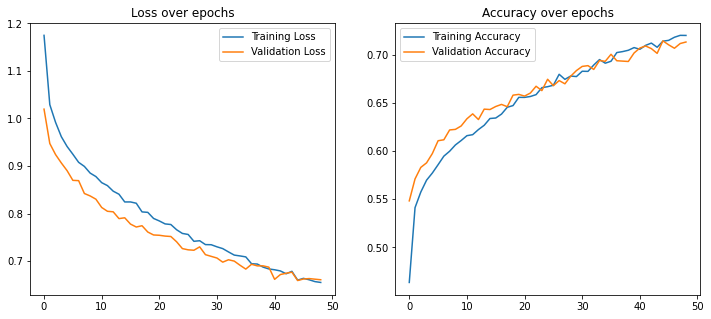

In [90]:
criterion = nn.CrossEntropyLoss()
trainable_params = filter(lambda p: p.requires_grad, model2.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
torch.autograd.set_detect_anomaly(True)

def train_epoch(epoch_index, train_loader, model, optimizer):
    model.train()  
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    model.eval() 
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

# Training loop
num_epochs = 50
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, model2, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, model2)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model2.state_dict(), 'model2.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

### Classification Report of the trained Modified EfficientNet B0

In [91]:
# classification report (test loader)
model2 = CNN2(num_classes=4).to(device)

model2.load_state_dict(torch.load('model2.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model2, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.70      0.75      0.72      1371
ModerateDemented       0.89      0.96      0.92       948
     NonDemented       0.70      0.68      0.69      1436
VeryMildDemented       0.61      0.54      0.57      1342

        accuracy                           0.71      5097
       macro avg       0.72      0.73      0.73      5097
    weighted avg       0.71      0.71      0.71      5097



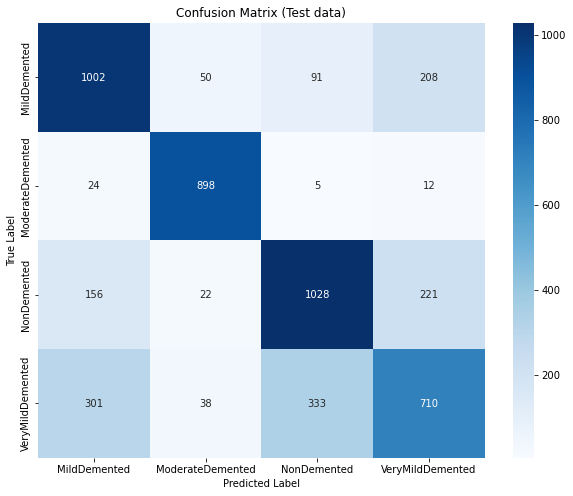

In [151]:
# Confusion Matrix on Test Loader - modified EfficientNet B0

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(model2, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Ensemble Model - Voting Classifier

In [13]:
class VotingEnsemble(nn.Module):
    def __init__(self, model1, model2):
        super(VotingEnsemble, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        # Get predictions from model1 and model2
        output1 = self.model1(x)
        output2 = self.model2(x)
        
        # softmax to convert to probabilities 
        prob1 = F.softmax(output1, dim=1)
        prob2 = F.softmax(output2, dim=1)
        
        # Average the probabilities 
        avg_probs = (prob1 + prob2) / 2
        
        return avg_probs

## Classification Report of the Ensemble Model

In [140]:
# classification report (test loader) - Ensemble Model
model1 = CNN2(num_classes=4).to(device)

model1.load_state_dict(torch.load('CNN2.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(ensemble_model, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.98      0.76      0.86      1351
ModerateDemented       0.80      1.00      0.89       939
     NonDemented       0.83      0.92      0.87      1427
VeryMildDemented       0.84      0.79      0.81      1382

        accuracy                           0.86      5099
       macro avg       0.86      0.87      0.86      5099
    weighted avg       0.87      0.86      0.86      5099



## Confusion Matrix of the Ensemble Model

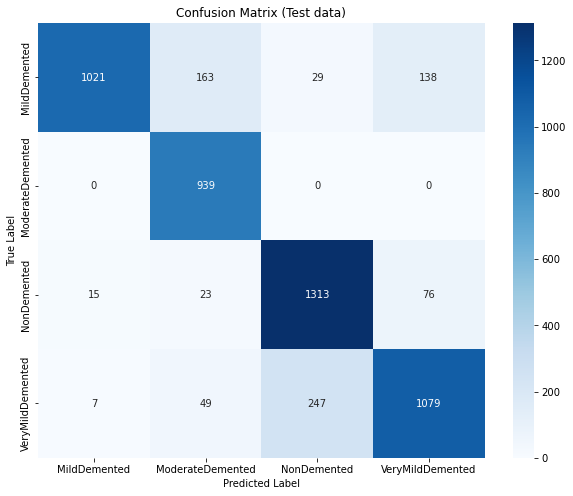

In [141]:
# Confusion Matrix on Test Loader

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(ensemble_model, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Upload an MRI and Predict AD Stage

In [14]:
model1 = CNN1(num_classes=4)
PATH1 = "/Users/savin/Desktop/FYP/Implementation/model1.pth"
model1.load_state_dict(torch.load(PATH1))

model2 = CNN2(num_classes=4)
PATH2 = "/Users/savin/Desktop/FYP/Implementation/model2.pth"
model2.load_state_dict(torch.load(PATH2))

model1.eval()
model2.eval()

ensemble_model = VotingEnsemble(model1, model2)

In [42]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path)# Convert to grayscale
    image = transform(image)
    image = image.repeat(3, 1, 1)  # Repeat the single channel three times to create a 3-channel image
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, model1, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-02-07 23:28:31.023 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:28:31.362 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:28:34.504 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:28:50.430 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:28:50.530 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:28:50.643 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:28:50.759 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:28:50.876 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:28:50.996 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:28:51.099 python[86682:6646539] +[CATransaction synchronize] called within tr

Predicted class: Non Demented
/Users/savin/Desktop/FYP/PSDP/Test_Dataset/nonDem2559.jpg


In [43]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path)# Convert to grayscale
    image = transform(image)
    image = image.repeat(3, 1, 1)  # Repeat the single channel three times to create a 3-channel image
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, model2, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-02-07 23:29:35.146 python[86682:6646539] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (19.56 secs).
2024-02-07 23:29:35.517 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:29:35.597 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:29:38.686 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:29:40.641 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:29:40.742 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:29:40.857 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:29:40.976 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:29:41.097 python[86682:66465

Predicted class: Non Demented
/Users/savin/Desktop/FYP/PSDP/Test_Dataset/nonDem2559.jpg


In [44]:
def load_and_predict(image_path, model, transform, device, class_names):
    model.eval()
    image = Image.open(image_path)# Convert to grayscale
    image = transform(image) 
    image = image.repeat(3, 1, 1)  # Repeat the single channel three times to create a 3-channel image
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

# Class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

Tk().withdraw()
image_path = filedialog.askopenfilename()

if image_path:
    predicted_class = load_and_predict(image_path, ensemble_model, preprocess_transform, device, class_names)
    print(f'Predicted class: {predicted_class}')
    print(image_path)
else:
    print("No file was selected.")

2024-02-07 23:29:56.959 python[86682:6646539] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (11.53 secs).
2024-02-07 23:29:57.128 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:29:57.258 python[86682:6646539] +[CATransaction synchronize] called within transaction
2024-02-07 23:29:58.897 python[86682:6646539] +[CATransaction synchronize] called within transaction


Predicted class: Non Demented
/Users/savin/Desktop/FYP/PSDP/Test_Dataset/nonDem2559.jpg


## Interpret Classification Result using Grad-CAM

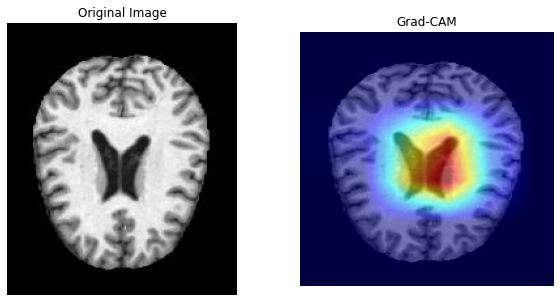

In [45]:
# Preprocessing function
def preprocess_image(image_path):
    # Open the image file
    image = Image.open(image_path)

    # Convert the image to RGB if it is not already
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Apply the preprocessing transforms
    image_tensor = preprocess_transform(image).unsqueeze(0).to(device)

    return image_tensor, image

# Grad-CAM function
def apply_gradcam(model, image_tensor, target_layer):
    gradcam = GradCAM(model, target_layer)
    mask, _ = gradcam(image_tensor)
    heatmap, result = visualize_cam(mask, image_tensor)

    return heatmap, result

# Load and preprocess image
input_image_path = image_path
image_tensor, original_image = preprocess_image(input_image_path)

# Apply Grad-CAM (adjust target layer as needed)
target_layer = model1.conv6  # Example: last conv layer in features
heatmap, cam_result = apply_gradcam(model1, image_tensor, target_layer)

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_result.permute(1, 2, 0).cpu().numpy())
plt.title('Grad-CAM')
plt.axis('off')

plt.show()